# Image Processing Cheatsheet

Notebook of snippets, tips, and tricks for working with images in Numpy and Pytorch

* https://github.com/soumith/the-incredible-pytorch
* https://github.com/pytorch/examples/blob/master/dcgan/main.py
* https://github.com/soumith/ganhacks
* https://github.com/alexis-jacq/Pytorch-Tutorials/blob/master/Neural_Style.ipynb

# Topics

* Load/Save Images/Tensors/Arrays
* View/Plot Images/Tensors/Arrays (determine size of plot)
* Display Grid of Images/Tensors/Arrays
* Normalize Images/Tensors/Arrays
* Denormalize Images/Tensors/Arrays
* Resize - Scale
* Resize - Crop (Random or Center Crop)
* Data Augmentation (Random flips, crops, etc.)
* Extract clean edges from images

# Imports

In [11]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_img_utils
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Pillow SIMD

* https://pillow.readthedocs.io/en/4.0.x
* https://github.com/uploadcare/pillow-simd
* https://python-pillow.org/pillow-perf/
* Pillow Original - 15.2 seconds per 4000 images
* Pillow-SIMD - 12.7 secs per 4000 images
How much faster is SIMD than Original?
* http://math.stackexchange.com/questions/1227389/what-is-the-difference-between-faster-by-factor-and-faster-by-percent
* (15.2 - 12.7) / 12.7 = ~20% faster
* 20% speedup

In [140]:
# Force uninstall old version, then install pillow-simd\n#$ pip uninstall pillow
#$ CC=\"cc -mavx2\" pip install -U --force-reinstall pillow-simd
#12 seconds per 4000 images
import PIL
print (PIL.PILLOW_VERSION)

4.0.0.post0


# File Management

In [ ]:
DATA_PATH = '/media/bfortuner/bigguy/data/animecolor/'
IMAGES_PATH = DATA_PATH + 'imgs/'
WEIGHTS_PATH = DATA_PATH + 'weights/'
RESULTS_PATH = DATA_PATH + 'results/'

In [142]:
def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
        fnames.extend([f for f in filenames])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

# Utils

In [3]:

#     if img_arr.shape[-1] != 3:
#         img_arr = np.swapaxes(img_arr,0,-1)    
#     return img_arr

def plot_img_path(img_path, fs=(6,6)):
    img = get_img(img_path)
    plot_img(img, fs)

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGE_MEAN)
    std = np.array(IMAGE_STD)
    inp = std * inp + mean
    return inp

def view_image(tensor, fs=(6,6)):
    """Imshow for Tensor."""
    inp = tensor #decode_image(tensor)
    plt.figure(figsize=fs)
    plt.imshow(inp)
    plt.show()
    
def plot_img_array(img_arr, fs=(16,16)):
    # Plot numpy array image with shape (inches?)
    plt.figure(figsize=fs)
    plt.imshow(img_arr.astype('uint8'))
    plt.show()

def plot_img(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.array(img))
    plt.show()
    
def get_img(img_path):
    return Image.open(img_path)

def show(img, fs=(6,6)):
    #Activation function is Tahn so we have to do some postprocessing to view the images
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

# Data

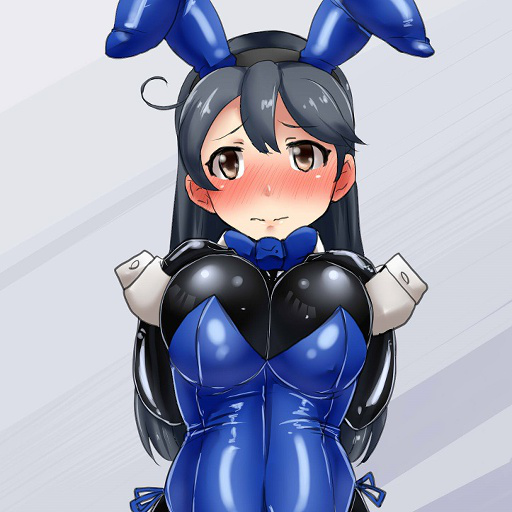

In [4]:
Image.open(get_random_image_path(IMAGES_PATH))

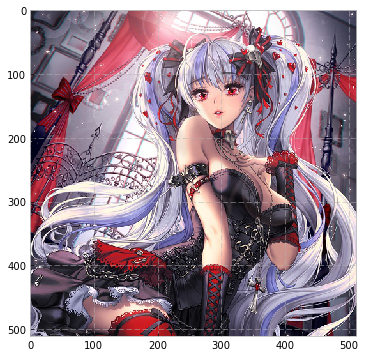

In [93]:
plot_img_path(get_random_image_path(IMAGES_PATH))

In [37]:
dataset = datasets.ImageFolder(root=IMAGES_PATH,
           transform=transforms.Compose([
                transforms.Scale(IMAGE_SIZE),
#                transforms.CenterCrop(IMAGE_SIZE),
               transforms.ToTensor()
           ]))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

### Normalize Images

* https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91
* https://github.com/pytorch/vision/blob/master/torchvision/utils.py
* np.array.mean() and np.array.std()

In [43]:
data_loader.batch_size = 8
inputs, labels = next(iter(data_loader))
print(inputs.size())

torch.Size([8, 3, 128, 128])


(128, 128, 3)
torch.Size([3, 128, 128])


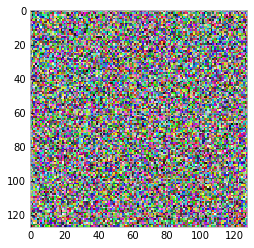

In [44]:
t1 = torch.randn(3,128,128)
t1.clamp()
#print(t1.size())
print(np.transpose(t1.numpy(), (1,2,0)).shape)   # So it flips the first channel axis with the last (input is the new ordering - 1,2,0)
plt.imshow(np.transpose(t1.numpy(), (1,2,0)), interpolation='nearest')
print(t1.size())

In [73]:
def norm_ip(t):
    # Why do we clamp?
    t = t.clamp(t.min(), t.max())

    #Why do we subtract min and then divide by range?
    return (t - t.min()) /(t.max() - t.min())

/media/bfortuner/bigguy/data/animecolor/imgs/all/20750.jpg


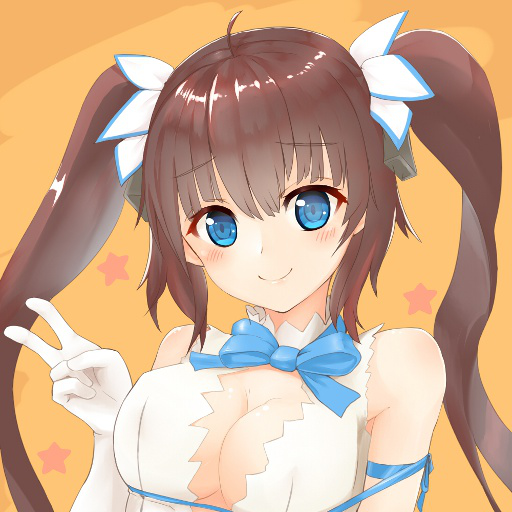

In [74]:
fpath = data_loader.dataset.imgs[0][0]
print(fpath)
Image.open(fpath)

torch.Size([3, 128, 128])


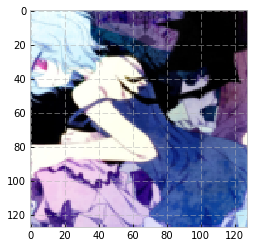

In [75]:
t1 = inputs[0]
print(t1.size())
show(t1)

# Converting Between Types

Imported PIL images has values between 0 and 255. Transformed into torch tensors, their values are between 0 and 1. This is an important detail: neural networks from torch library are trained with 0-1 tensor image. If you try to feed the networks with 0-255 tensor images the activated feature maps will have no sens.

In [249]:
img_path = get_random_image_path(IMAGES_PATH)

In [304]:
# PIL to numpy
pil_img = Image.open(img_path)
print("PIL",pil_img.size,type(pil_img)) #hides number of channels (3)
np_from_pil = np.array(pil_img)
print("NumpyFromPIL", np_from_pil.shape, type(np_from_pil)) #Channels is visible as last param (3)

# Numpy to PIL
# http://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap
pil_from_numpy = Image.fromarray(np_from_pil)
print("PILfromNumpy", pil_from_numpy.size, type(pil_from_numpy))

## PIL to Tensor
tns = transforms.ToTensor()(pil_img)
print("Tensor", tns.size(), type(tns))

# Tensor to PIL (also handles numpy arrays)
pil_from_tensor = transforms.ToPILImage()(tns)
print("PilFromTensor", pil_from_tensor.size, type(pil_from_tensor))

# Tensor to Numpy
np_from_tensor = tns.numpy()
print("NumpyFromTensor", np_from_tensor.shape, type(np_from_tensor)) #Channel dim order now in Pytorch language

# Numpy to Tensor
np_to_tensor = torch.from_numpy(np_from_tensor)
print("NumpyToTensor", np_to_tensor.size(), type(np_to_tensor))


PIL (512, 512) <class 'PIL.JpegImagePlugin.JpegImageFile'>
NumpyFromPIL (512, 512, 3) <class 'numpy.ndarray'>
PILfromNumpy (512, 512) <class 'PIL.Image.Image'>
Tensor torch.Size([3, 512, 512]) <class 'torch.FloatTensor'>
PilFromTensor (512, 512) <class 'PIL.Image.Image'>
NumpyFromTensor (3, 512, 512) <class 'numpy.ndarray'>
NumpyToTensor torch.Size([3, 512, 512]) <class 'torch.FloatTensor'>


In [301]:
# Cool method that handles both Numpy and Tensor --> to PIL conversion
def unload_img_tensor_or_array(img_tensor_or_np_arr):
    """Converts
    torch.*Tensor of shape C x H x W  
        OR
    numpy ndarray of shape H x W x C 
    to PIL.Image while preserving value range
    """
    return transforms.ToPILImage()(img_tensor_or_np_arr)

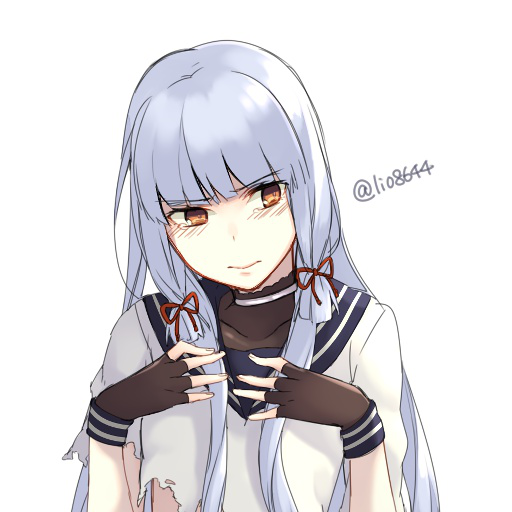

In [308]:
pil_out_t = unload_img_tensor_or_array(tns)
pil_out_n = unload_img_tensor_or_array(np_from_pil)
pil_out_n

# Image Loading

In [288]:
img_path = get_random_image_path(IMAGES_PATH)

In [310]:
def load_img_as_pil(img_path):
    return Image.open(img_path)

def load_img_as_np_arr(img_path):
    pil_image = Image.open(img_path)
    return np.array(pil_image)

def load_img_as_tensor(img_path):
    pil_image = Image.open(img_path)
    return transforms.ToTensor()(pil_img)

def load_img_as_tensor_w_transforms(img_path, transforms):
    pil_image = Image.open(img_path)
    return transforms(pil_image) #Optionally wrap in Variable()

In [313]:
#Load image as PIL
pil_image = load_img_as_pil(img_path)
print("PIL --",pil_image.size, pil_image.filename)

print("Stats -- Size, Mean, Std, Min, Max")

#Load image as numpy array
img_np_arr = load_img_as_np_arr(img_path)
print("Numpy --",img_np_arr.shape, img_np_arr.mean(), img_np_arr.std(), img_np_arr.min(), img_np_arr.max())

#Load image as tensor
img_tensor = load_img_as_tensor(img_path)
print("Tensor --",img_tensor.size(), img_tensor.mean(), 
      img_tensor.std(), img_tensor.min(), img_tensor.max())

#Load image as tensor w transforms
augmentations = transforms.Compose([
    transforms.Scale(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()])
img_tensor_w_trans = load_img_as_tensor_w_transforms(img_path, augmentations)
print("TnsWTrans --",img_tensor_w_trans.size(), img_tensor_w_trans.mean(), 
      img_tensor_w_trans.std(), img_tensor_w_trans.min(), img_tensor_w_trans.max())

PIL -- (512, 512) /media/bfortuner/bigguy/data/animecolor/imgs/all/6341.jpg
Stats -- Size, Mean, Std, Min, Max
Numpy -- (512, 512, 3) 220.875912984 59.435324589 0 255
Tensor -- torch.Size([3, 512, 512]) 0.8661800548336215 0.23307984931225864 0.0 1.0
TnsWTrans -- torch.Size([3, 128, 128]) 0.8662596905852903 0.21475671767313764 0.08627451211214066 1.0


# Image Saving

In [291]:
img_path = get_random_image_path(IMAGES_PATH)

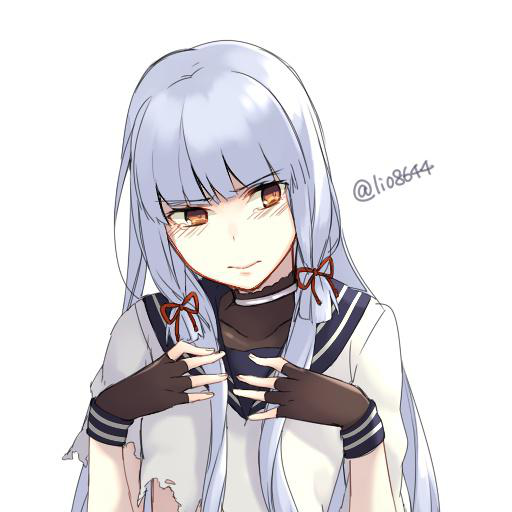

In [292]:
pil_image = Image.open(img_path)
pil_image.save('tmp.jpg')
out_image = Image.open('tmp.jpg')
os.remove('tmp.jpg')
out_image

# Normalization

In [327]:
def norm_minmax(t, new_min, new_max):
    """
    Clamp (like 'clip') sets all values below "min" to "min"
    and all values above the "max", to "max"""    
    t = t.clamp(t.min(), t.max())

    #Why do we subtract min and then divide by range?
    return (t - t.min()) /(t.max() - t.min())

def denorm_minmax(t, old_min, old_max):
    #Multiply by range, then add min?
    return t * (old_max - old_min) + old_min

def norm_meanstd(t, mean, std):
    """The Pytorch transforms module does this
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor
    channel = (channel - mean) / std"""
    return (t-mean) / std

def denorm_meanstd(t, mean, std):
    return (t * std) + mean

In [355]:
t1 = torch.randn(3,128,128)
tmin, tmax = t1.min(), t1.max()
norm_i = norm_ip(t1)
denorm_i = denorm(norm_i, tmin, tmax)
print("Input",t1.size(), t1.min(), t1.max(), t1.mean(), t1.std())
print("Normalized",norm_i.size(), norm_i.min(), norm_i.max(), norm_i.mean(), norm_i.std())
print("Denormalized",denorm_i.size(), denorm_i.min(), denorm_i.max(), denorm_i.mean(), denorm_i.std())

Input torch.Size([3, 128, 128]) -3.847280740737915 5.053558826446533 0.00225807990487518 0.9980431474928373
Normalized torch.Size([3, 128, 128]) 0.0 1.0 0.43249164185982636 0.11212909894071511
Denormalized torch.Size([3, 128, 128]) -3.847280740737915 5.053559303283691 0.0022580804773800387 0.9980431478795164


# Clip/Clamp

In [354]:
def clip_tensor(t, min_val, max_val):
    """return new tensor w all values smaller than min_val
    set to min all values larger than max_val set to max"""
    return t.clamp(min_val,max_val)

def clip_numpy(np_arr, min_val, max_val):
    """return new numppy array w all values smaller than min_val
    set to min all values larger than max_val set to max"""
    return np_arr.clip(min_val, max_val)

# Inputs
t = torch.range(0,10)
print(t.view(1,-1))
n = np.arange(0,11)
print(n)

# Clip Tensor
ct = t.clamp(3,6)
print(ct1.view(1,-1))

# Clip Numpy
cn = n.clip(3,6)
print(cn)


    0     1     2     3     4     5     6     7     8     9    10
[torch.FloatTensor of size 1x11]

[ 0  1  2  3  4  5  6  7  8  9 10]

    3     3     3     3     4     5     6     6     6     6     6
[torch.FloatTensor of size 1x11]

[3 3 3 3 4 5 6 6 6 6 6]


# View Images

In [356]:
img_path = get_random_image_path(IMAGES_PATH)

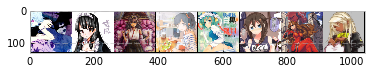

In [47]:
def preview_img(img):
    #Takes PIL, Tensor, or Np Array and plots it
    if type(img) == PIL.image:
        #plot image directly
        pass
    elif type(img) == np.array:
        #plot numpy arr
        pass
    elif type(img) == torch.Tensor:
        #plot torch tensor
        pass

def show(img):
    npimg = img.numpy()
    #swap the 1st axis with the last (input is the new ordering - 1,2,0) - plotly expects final dim to be channel
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torch_img_utils.make_grid(inputs, normalize=True))

# Augmentation

Everything in both Numpy and Pytorch

* Center Crop
* Random Flips
* Random Crop
* Scale
* Padding
* Lambda function as input (Pytorch)

## Center Crop

### Numpy

In [183]:
a = np.random.rand(5,5)
print("Input")
print(a.shape)
print(a)
rows = a.shape[0]
cols = a.shape[1]

new_rows, new_cols = (3,3)
print((5-3)//2)

#Where to start in our crop
crop_rows_start = (rows-new_rows)//2
crop_cols_start = (cols-new_cols)//2
print("Start", crop_rows_start, crop_cols_start)

#Where to end in our crop
crop_rows_end = crop_rows_start + new_rows
crop_cols_end = crop_cols_start + new_cols
print("End", crop_rows_end, crop_rows_end)

cropped_arr = a[crop_rows_start:crop_rows_end, crop_cols_start:crop_cols_end]

print("Output")
print(cropped_arr.shape)
print(cropped_arr)

Input
(5, 5)
[[ 0.7865177   0.0546573   0.94625782  0.84901808  0.29934303]
 [ 0.89579776  0.52086283  0.90629181  0.13152154  0.84667911]
 [ 0.79925407  0.30260106  0.5443943   0.33317319  0.50410262]
 [ 0.49902075  0.64567722  0.88782574  0.90803267  0.79267931]
 [ 0.89683235  0.1839385   0.85797997  0.83987068  0.50992377]]
1
Start 1 1
End 4 4
Output
(3, 3)
[[ 0.52086283  0.90629181  0.13152154]
 [ 0.30260106  0.5443943   0.33317319]
 [ 0.64567722  0.88782574  0.90803267]]


In [205]:
def center_crop_2d(np_arr, size=(128,128)):
    """
    np_arr: = np array of how many dims?
    Size: = (rows, cols)"""
    rows, cols = np_arr.shape
    new_rows, new_cols = size
    
    start_row = (rows - new_rows) // 2
    start_col = (cols - new_cols) // 2
    end_row = start_row + new_rows
    end_col = start_col + new_cols
    return np_arr[start_row:end_row, start_col:end_col]

In [ ]:
# Test 2D
inp = np.random.rand(5,5)
print("Input", inp.shape)
print(inp)

out = center_crop_2d(inp,(3,3))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(5,5))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(2,2))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(1,1))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(1,3))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(3,2))
print("Output", out.shape)
print(out)

In [ ]:
def center_crop_3d(np_arr, size=(128,128)):
    """
    np_arr: = np array of how many dims?
    Size: = (rows, cols)"""
    rows, cols, depth = np_arr.shape
    new_rows, new_cols = size
    
    start_row = (rows - new_rows) // 2
    start_col = (cols - new_cols) // 2
    end_row = start_row + new_rows
    end_col = start_col + new_cols
    return np_arr[start_row:end_row, start_col:end_col, :]

# Test 3D
inp = np.random.rand(5,5,3) #3rd is channels
print("Input", inp.shape)
print(inp)

out = center_crop_3d(inp,(3,3))
print("Output", out.shape)
print(out)

### Pytorch

# Datasets

* Load Images from Directory
* Load Dataset from Pytorch Library (LSUN, MNIST, Pascal VOC) 

In [ ]:
dataset = datasets.ImageFolder(root=IMAGES_PATH,
           transform=transforms.Compose([
               transforms.Scale(IMAGE_SIZE),
               transforms.CenterCrop(IMAGE_SIZE),
               transforms.ToTensor(),
               transforms.Normalize(torch.FloatTensor(IMAGE_MEAN), torch.FloatTensor(IMAGE_STD)),
           ]))

# Data Loaders

* Custom image loader in Numpy
* Image Loader in Pytorch (w transforms)

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Extras

In [ ]:


BATCH_SIZE = 1
IMAGE_SIZE = 128
IMAGE_MEAN = None
IMAGE_STD = None
SEED = 1
torch.cuda.manual_seed(SEED)

# Resources